# Apriori Algorithm on Grocery Data

Dataset available at: https://www.kaggle.com/datasets/morecoding/transactiongrocery

### Reading the data in

In [1]:
import time
import pandas as pd
import numpy as np

groceries = pd.read_csv('groceries.csv')
print('Data shape:', groceries.shape)
print()
groceries.head()

Data shape: (9835, 33)



,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Looking at all unique items and their counts in the data

In [2]:
transactions = []
groceries_flat = groceries.values.tolist()
for i in groceries_flat:
    item_list = []
    for j in range(1, i[0]+1):
        item_list.append(i[j])
    transactions.append(item_list)
total_transactions = len(transactions)
total_transactions

9835

In [3]:
from functools import reduce
from collections import Counter

tr = reduce(lambda a, b : a + b, transactions)
items = dict(Counter(tr))
len(items)

169

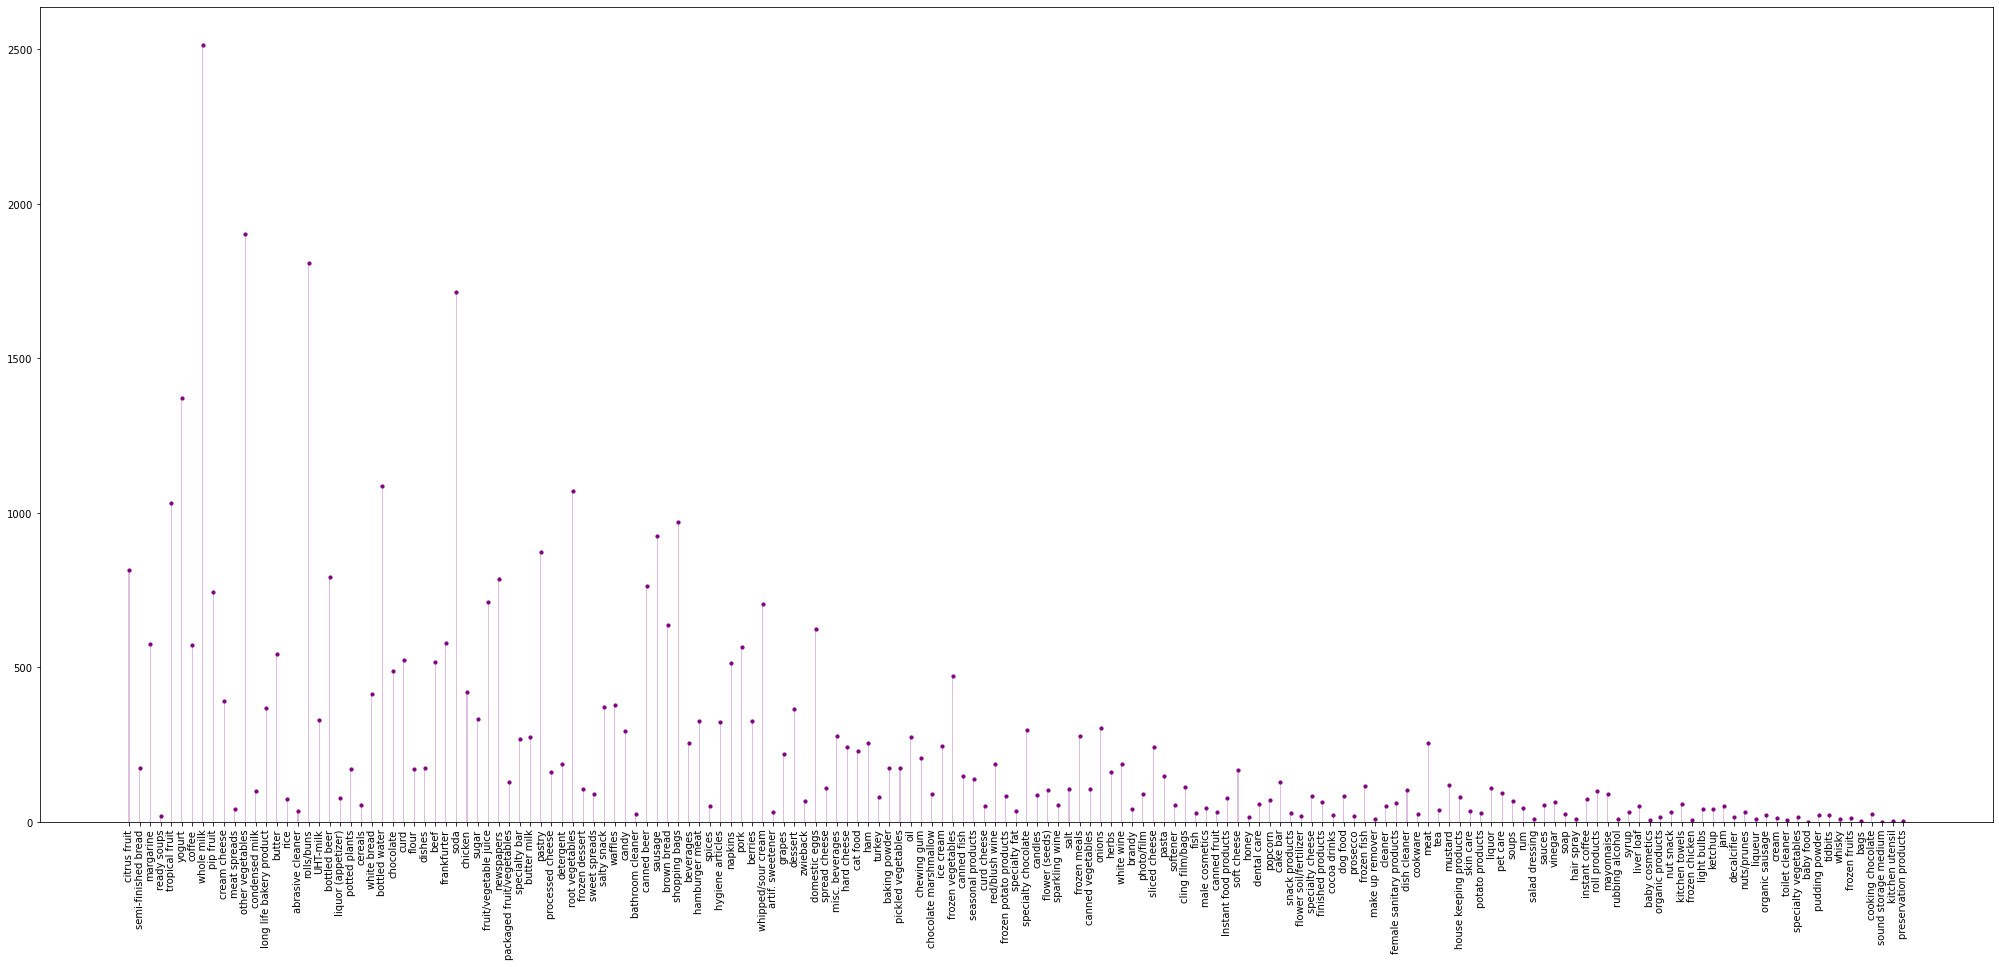

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (35, 15))
plt.bar(items.keys(), items.values(), width = 0.1, color = 'purple', alpha = 0.25)
plt.scatter(items.keys(), items.values(), color = 'purple', s = 10)
plt.xticks(rotation = 90)
plt.show()

### Functions for Apriori

##### Pruning the 1-itemsets

In [5]:
def prune(items):
    pruned_items = {}
    for i in items:
        if items[i]/total_transactions > minsup:
            pruned_items[i] = items[i]
    print('1-itemsets are ready')
    return pruned_items

##### Pruning the 2-itemsets

In [6]:
import itertools

def pair_prune(items):
    pairs = [pair for pair in itertools.combinations(list(items.keys()), 2)]
    itemset_2 = {}
    for i in pairs:
        c = 0
        for j in transactions:
            if set(i).issubset(set(j)):
                c += 1
        if c/total_transactions >= minsup:
            itemset_2[i] = c
    print('2-itemsets are ready')
    return itemset_2

##### k-1 x k-1 approach to generate frequent itemsets

In [7]:
def k_itemsets_fk(minsup, itemlist, k = 3):
    st = time.time()
    count_sets = 0
    final = itemlist
    while len(itemlist) > 1:
        final = itemlist
        itemset = {}
        iter_list = [pair for pair in itertools.combinations(list(itemlist.keys()), 2)]
        for i in iter_list:
            count_sets += 1
            s = set(i[0]) | set(i[1])
            c = 0
            s = set(sorted(s))
            for t in transactions:
                if s.issubset(set(t)):
                    c += 1
            if c/total_transactions >= minsup and len(s) == k:
                    itemset[tuple(s)] = c
        itemlist = itemset
        k += 1
    et = time.time()
    print("\nFrequent itemset generation using k-1 * k-1 approach. Total itemsets looked at:", count_sets)
    print("Found", len(final), "frequent itemsets in", et - st, "seconds")
    return final

###### k-1 x 1 approach to generate frequent itemsets

In [8]:
def k_itemsets_f1(minsup, items_k_1, k = 3):
    st = time.time()
    final = items_k_1
    items_1 = set(reduce(lambda a, b : a + b, items_k_1.keys()))
    count_sets = 0
    while len(items_k_1) > 1:
        final = items_k_1
        itemset = {}
        for i in set(items_k_1.keys()):
            for j in items_1:
                if j not in i:
                    count_sets += 1
                    s = set(i)
                    s.add(j)
                    c = 0
                    s = set(sorted(s))
                    for t in transactions:
                        if s.issubset(set(t)):
                            c += 1
                    if c/total_transactions >= minsup and tuple(s) not in itemset.keys():
                        itemset[tuple(s)] = c
        items_k_1 = itemset
        k += 1
    et = time.time()
    print("\nFrequent itemset generation using k-1 * 1 approach. Total itemsets looked at:", count_sets)
    print("Found", len(final), "frequent itemsets in", et - st, "seconds")
    return final

##### Association rule generation

In [9]:
def get_ruleset(size, rules):
    ruleset = []
    for i in range(1, size):
        for j in rules:
            if i == 1:
                for k in j:
                    r = [set(j) - {k}, {k}]
                    ruleset.append(r)
            else:
                sets = [set(s) for s in itertools.combinations(j, i)]
                for s in sets:
                    r = [set(j) - s, s]
                    ruleset.append(r)
    return ruleset

In [10]:
def final_rules(ruleset):
    association_rules = []
    confidence = []
    for i in ruleset:
        c1 = 0
        c2 = 0
        for t in transactions:
            if i[0].issubset(set(t)):
                c1 += 1
            if i[0].issubset(set(t)) and i[1].issubset(set(t)):
                c2 += 1
        conf = c2/c1
        if conf >= minconf:
            association_rules.append(i)
            confidence.append(conf)
    return association_rules, confidence

### Executing for different support and confidence values

In [11]:
supp_values = [0.04, 0.01, 0.005]
conf_values = [0.2, 0.3, 0.4]

for minsup in supp_values:
    print('\n\n\nCalculating frequent itemsets for support value =', minsup)
    pruned_items = prune(items)
    itemset_2 = pair_prune(pruned_items)
    k_itemset_1 = k_itemsets_fk(minsup, itemset_2)
    k_itemset_2 = k_itemsets_f1(minsup, itemset_2)
    if k_itemset_1 == k_itemset_2:
        k_itemset = k_itemset_1
    for minconf in conf_values:
        print('\nGenerating association rules for confidence value =', minconf)
        size = len(list(k_itemset.keys())[0])
        rules = list(k_itemset.keys())
        ruleset = get_ruleset(size, rules)
        association_rules, confidence = final_rules(ruleset)
        for a, c in zip(association_rules, confidence):
            print(a[0], '   ->   ', a[1], '          with confidence =', c)




Calculating frequent itemsets for support value = 0.04
1-itemsets are ready
2-itemsets are ready

Frequent itemset generation using k-1 * k-1 approach. Total itemsets looked at: 36
Found 9 frequent itemsets in 0.09777498245239258 seconds

Frequent itemset generation using k-1 * 1 approach. Total itemsets looked at: 45
Found 9 frequent itemsets in 0.13300800323486328 seconds

Generating association rules for confidence value = 0.2
{'tropical fruit'}    ->    {'whole milk'}           with confidence = 0.40310077519379844
{'whole milk'}    ->    {'yogurt'}           with confidence = 0.2192598487863112
{'yogurt'}    ->    {'whole milk'}           with confidence = 0.40160349854227406
{'other vegetables'}    ->    {'yogurt'}           with confidence = 0.22438255386232264
{'yogurt'}    ->    {'other vegetables'}           with confidence = 0.3112244897959184
{'other vegetables'}    ->    {'whole milk'}           with confidence = 0.38675775091960063
{'whole milk'}    ->    {'other veget